In [1]:
import csv
import requests

# download some tweets (Trump dataset from Kaggle)
r = requests.get('https://lab-data-collections.s3.amazonaws.com/realdonaldtrump.csv')
with open('tweets.csv', 'w') as out:
    out.write(r.text)

In [2]:
# process the csv of tweets to grab just the text content
l = []
with open('tweets.csv') as f:
    reader = csv.reader(f)
    for i in reader:
        l.append(i[2])
l = l[1:]

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# prepare to build a topic model
n_topics = 100                     

vectorizer = TfidfVectorizer(
  input = 'content',               # indicate that we will run the vectorizer on string inputs
  stop_words = 'english',          # remove the default English language stopwords from each document
  min_df = 2,                      # only retain words that occur n+ times
  max_df = 0.95,                   # only include words that occur in fewer than n% of documents
  max_features = 1000 * n_topics,  # only retain a total of n words
)

In [4]:
from sklearn.decomposition import NMF

# create the model we'll use to perform topic modeling
model = NMF(
  n_components = n_topics,
  random_state = 1,
  init = 'nndsvda',
)

In [6]:
# create the term document matrix
documents_by_terms = vectorizer.fit_transform(l)

# get the list of words/terms in our corpus (the columns in D)
words = vectorizer.get_feature_names()

# Get matrix W -- one row per document, one column per topic
documents_by_topics = model.fit_transform(documents_by_terms)

# Get matrix T -- one row per topic, one column per unique word
topics_by_terms = model.components_

In [20]:
from umap import UMAP

# project the documents by topics matrix to shape (documents, 2)
z = UMAP(n_neighbors=6).fit_transform(documents_by_topics)

In [14]:
# create a 1D projection for colors too
colors = UMAP(n_components=1).fit_transform(documents_by_topics)

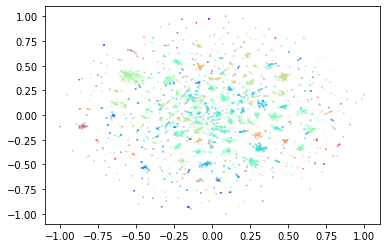

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

z = minmax_scale(z, feature_range=(-1,1))
colors = minmax_scale(colors, feature_range=(0,1))

plt.scatter(*z.T, s=0.001, color=cm.rainbow(colors))

In [19]:
from sklearn.preprocessing import minmax_scale
import numpy as np
import json
import os

scaled = minmax_scale(z)
out_dir = os.path.join('client', 'assets', 'data')

with open(os.path.join(out_dir, 'positions.json'), 'w') as out:
    json.dump(z.tolist(), out)
    
with open(os.path.join(out_dir, 'texts.json'), 'w') as out:
    json.dump(l, out)
    
with open(os.path.join(out_dir, 'colors.json'), 'w') as out:
    json.dump(colors.tolist(), out)